In [3]:
import sys  
sys.path.insert(0, '/home/yiyi/nlp_tm/models/DETM')

In [6]:
import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

In [33]:
num_topics = 10

input_dir = f"k_{num_topics}"
file  = f'~/nlp_tm/models/DETM/k_{num_topics}/df_detm_topics_k{num_topics}_confidence.csv'

In [34]:
df = pd.read_csv(file, index_col=0)

In [35]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,3,-0.010247
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,7,-0.011539
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,7,-0.008543
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,7,-0.006665
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,7,-0.009725


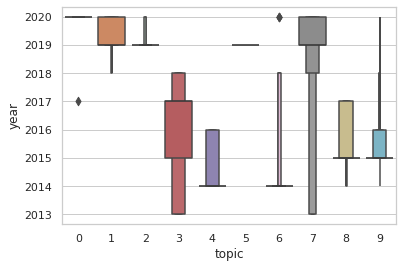

In [49]:
sns.set_theme(style="whitegrid")
sns.boxenplot(y='year', x='topic', data=df)

Text(0.5, 1.0, 'The Distribution of Tweets with 10 Topics After Filtering')

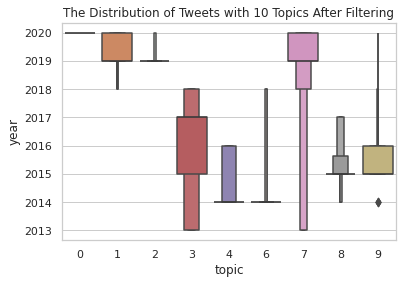

In [52]:
sns.set_theme(style="whitegrid")
sns.boxenplot(y='year', x='topic', data=df[df['relevant']==True])
plt.title(f'The Distribution of Tweets with {num_topics} Topics After Filtering')

In [39]:
df['relevant']= df['cossim']>0

In [36]:
df['cossim'].value_counts

<bound method IndexOpsMixin.value_counts of id
285908615561363456    -0.010247
285909630868152320    -0.011539
285915248383361026    -0.008543
285921849446117376    -0.006665
285922536942866432    -0.009725
                         ...   
1344791154005573632    0.065577
1344792331766083584    0.063060
1344793429360959491    0.044342
1344793756189544450    0.072482
1344795058332184577    0.041535
Name: cossim, Length: 360097, dtype: float64>

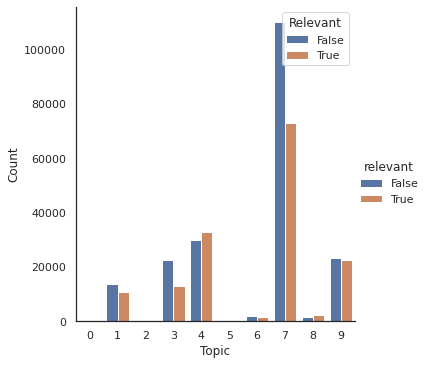

In [44]:
sns.set_theme(style="white")
g= sns.catplot(x="topic", hue="relevant", data=df, kind="count")
plt.legend(loc='upper right', title='Relevant')
g.set(xlabel= 'Topic', ylabel='Count')
plt.savefig(f'/home/yiyi/nlp_tm/models/DETM/k_{num_topics}/dist_bef_after_{num_topics}.png')

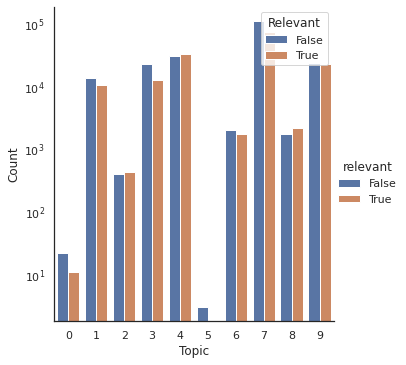

In [41]:
sns.set_theme(style="white")
g= sns.catplot(x="topic", hue="relevant", data=df, kind="count")
plt.legend(loc='upper right', title='Relevant')
plt.yscale('log')
g.set(xlabel= 'Topic', ylabel='Count')

In [22]:
df['relevant'] = df['cossim']>0

In [23]:
df

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,euclidean,cossim,relevant
id,,,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,0,1.276156,-0.041755,False
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,0,1.298936,-0.038137,False
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,0,1.380190,-0.041893,False
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,0,1.444284,-0.045503,False
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,0,1.458056,-0.033794,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344791154005573632,"[1431, 10434, 1206, 6258, 13960, 2093, 8090, 9...",7,GB,1344791154005573632,As #Europe is one hour ahead of #Britain they ...,2020-12-31T23:42:50.000Z,"{'place_id': '609de05ff9db5cfe', 'place': {'fu...",108713501,"{'hashtags': [{'start': 3, 'end': 10, 'tag': '...",2020,12,31,europe hour ahead britain celebrate newyear bl...,0,0.656159,-0.021834,False
1344792331766083584,"[10314, 4018, 20597, 7278, 10915, 985]",7,IT,1344792331766083584,"#LeaveALightOnForScotland, because #Scotland w...",2020-12-31T23:47:31.000Z,"{'place_id': '0f14a0bc5fea038d', 'place': {'fu...",492589316,"{'hashtags': [{'start': 0, 'end': 25, 'tag': '...",2020,12,31,leavealightonforscotland scotland soon europea...,0,0.645253,0.013753,True
1344793429360959491,"[17683, 14049, 1833, 1457]",7,GB,1344793429360959491,Pass it on #IndyScotland21 #ScotlandinEU #Scot...,2020-12-31T23:51:53.000Z,"{'place_id': '73cc26d418860ddd', 'place': {'fu...",151383933,"{'hashtags': [{'start': 11, 'end': 26, 'tag': ...",2020,12,31,pass indyscotland scotlandineu scotlandineurop...,0,0.721288,-0.021813,False


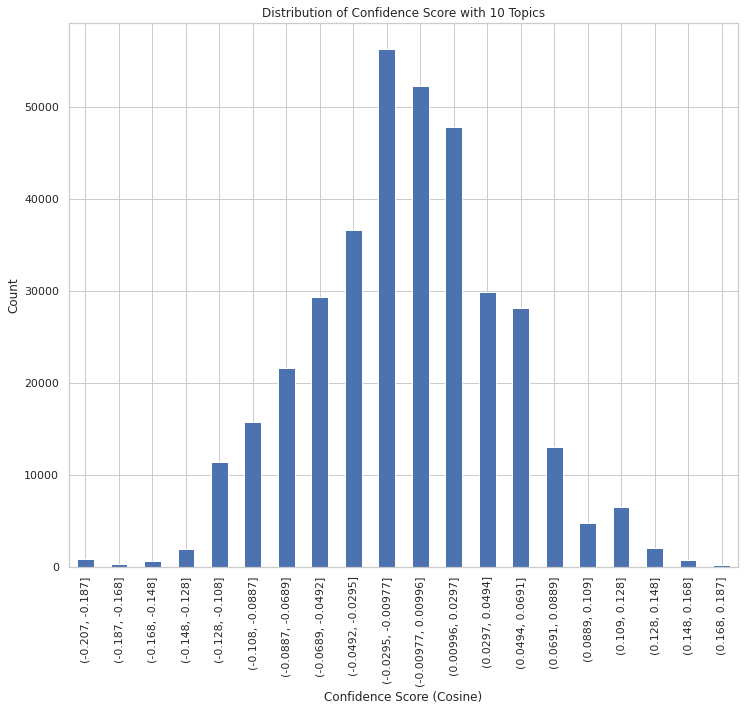

In [81]:
plt.figure(figsize=(12,10))
df['text'].groupby(pd.cut(df['cossim'], 20)).count().plot(kind='bar')
plt.xlabel('Confidence Score (Cosine)')
plt.ylabel('Count')
plt.title('Distribution of Confidence Score with 10 Topics')
plt.savefig('dist.png', bbox_inches='tight')

In [ ]:
df[]

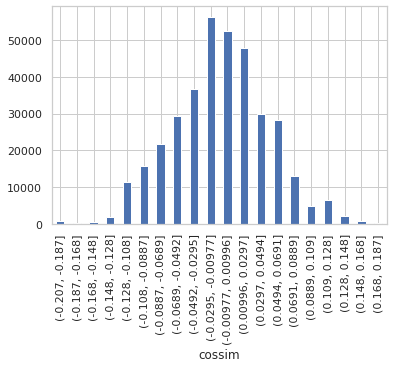

In [59]:
ax = df['text'].groupby(pd.cut(df['cossim'], 20)).count().plot(kind='bar')

In [69]:
ax.set_xlabel('Cosine Similarity Score')
ax.set_title('Distribution of the Confidence Score of Tweets')
ax.figure.savefig('dist.png')

In [68]:
ax.figure.savefig('dist.png')

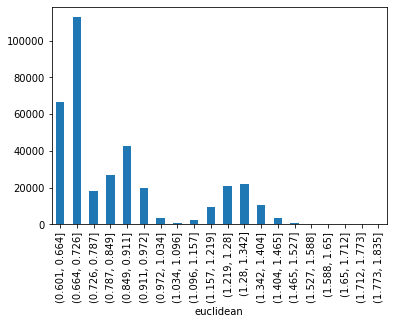

In [16]:
df['text'].groupby(pd.cut(df['euclidean'], 20)).count().plot(kind='bar')